In [1]:
import pprint
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
from kmodes.kmodes import KModes

%matplotlib inline

In [2]:
Summary = namedtuple(
    "Summary",
    [
        "name",
        "num_rows",
        "num_cols",
        "num_classes",
        "missing_values",
        "adjusted_num_rows",
        "adjusted_num_classes",
    ],
)

summaries = []
for dataset_name in ("breast_cancer", "mushroom", "soybean", "zoo"):

    df = pd.read_csv(f"../data/{dataset_name}.csv", na_values=["?", "dna"])

    classes = df["class"]
    df = df.drop("class", axis=1)

    dropped_df = df.dropna()
    missing_values = len(dropped_df) != len(df)

    nrows, ncols = df.shape
    nclasses = classes.nunique()
    adjusted_nrows = len(dropped_df)
    adjusted_nclasses = classes.iloc[dropped_df.index].nunique()

    summaries.append(
        Summary(
            dataset_name,
            nrows,
            ncols,
            nclasses,
            missing_values,
            adjusted_nrows,
            adjusted_nclasses,
        )
    )


In [3]:
summary_df = pd.DataFrame(summaries).set_index("name")
summary_df.index = [" ".join(name.split("_")).capitalize() for name in summary_df.index]
summary_df.columns = [
    " ".join(col.replace("num", "no.").split("_")).capitalize()
    for col in summary_df.columns
]

summary_df.to_latex("../tex/dataset_summary.tex")
summary_df


,No. rows,No. cols,No. classes,Missing values,Adjusted no. rows,Adjusted no. classes
Breast cancer,699,9,2,True,683,2
Mushroom,8124,22,2,True,5644,2
Soybean,307,35,19,True,266,15
Zoo,101,17,7,False,101,7


In [4]:
dataset_costs = {}
for dataset_name in ("breast_cancer", "mushroom", "soybean", "zoo"):

    df = pd.read_csv(f"../data/{dataset_name}.csv", na_values=["?", "dna"])
    df = df.drop("class", axis=1).dropna()

    costs = []
    cluster_range = range(2, int(np.sqrt(len(df))) + 1)
    for k in tqdm.tqdm(cluster_range):
        km = KModes(
            n_clusters=k,
            init="cao",
            random_state=0,
        ).fit(df)
        costs.append(km.cost_)

    dataset_costs[dataset_name] = costs


100%|██████████| 9/9 [00:00<00:00, 16.79it/s]


In [5]:
def find_optimal_nclusters(costs):
    """ Find the optimal number of clusters for a dataset by
    maximising the distance between the cost associated with
    that value of k and the line defined by the first and
    last costs. """

    start, end = np.array(
        [[2, costs[0]], [len(costs) + 2, costs[-1]]]
    )

    points = np.array(list(zip(range(2, len(costs) + 3), costs)))
    distances = np.cross(end - start, start - points) / np.linalg.norm(end - start)

    return distances.argmax() + 2


for name, costs in dataset_costs.items():
    
    print(name, find_optimal_nclusters(costs))

breast_cancer 10
mushroom 17
soybean 6
zoo 4


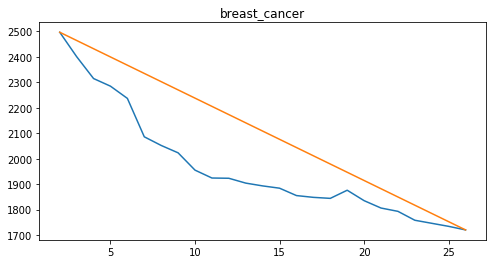

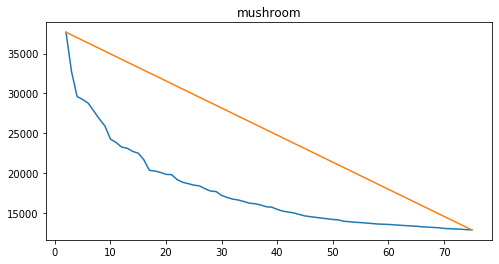

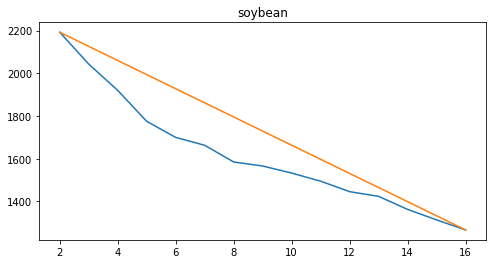

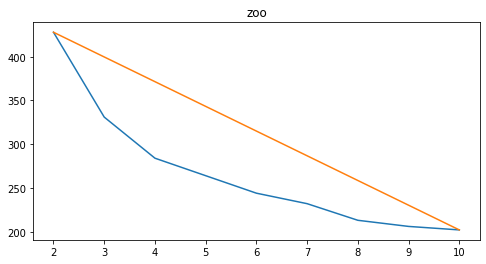

In [6]:
for name, costs in dataset_costs.items():

    fig, ax = plt.subplots(figsize=(8, 4))

    ax.plot([i+2 for i in range(len(costs))], costs)
    ax.plot((2, len(costs) + 1), (costs[0], costs[-1]))
    ax.set_title(name)